## `artemis` - porównanie działania metod model-agnostic 

Benchmark przeprowadzono na najpopularniejszym syntetycznym zbiorze danych wykorzystywanym w literaturze dot. interakcji w modelach predykcyjnych. Pochodzi on z pracy *Discovering Additive Structure in Black Box Functions* (Hooker, 2004). 

Dataset jest generowany na podstawie funkcji postaci: 
$$ F(x) = \pi^{x_1x_2}\cdot \sqrt{2x_3} - \sin^{-1}(x_4) + \log(x_3+x_5) - \frac{x_9}{x_{10}} \sqrt{\frac{x_7}{x_8}} - x_2x_7.$$

Zmienne $x_1, x_2, x_3, x_6, x_7, x_9$ są rozkładu jednostajnego $U(0, 1)$, a zmienne $x4, x5, x8, x10$ z rozkładu jednostajnego $U(0.6, 1)$. 

Spodziewane interakcje par zmiennych (przy założeniu ***idealnego*** modelu) to: 
- pary zmiennych z pierwszego składnika funkcji: 
    - $(x_1, x_2)$,
    - $(x_1, x_3)$,
    - $(x_2, x_3)$,
- para zmiennych z ostatniego składnika funkcji:
    - $(x_2, x_7)$,
- para zmiennych z trzeciego składnika funkcji: 
    - $(x_3, x_5)$,
- pary zmiennych z czwartego składnika funkcji:
    - $(x_7, x_8)$,
    - $(x_7, x_9)$,
    - $(x_7, x_{10})$,
    - $(x_8, x_9)$,
    - $(x_8, x_{10})$,
    - $(x_9, x_{10})$.

Należy pamiętać, że generowane wyjaśnienia mają być prawdziwe dla modelu, nie danych - zatem nie wszystkie interakcje muszą być znalezione przez model. 
Natomiast w przypadku tak prostej funkcji najważniejsze interakcje powinny się pokrywać.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod, GreenwellMethod, SejongOhMethod
from artemis.interactions_methods.model_specific import ConditionalMinimalDepthMethod, SplitScoreMethod
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()
X1_3 = rng.uniform(0, 1, 15000).reshape((5000, 3))
X4_5 = rng.uniform(0.6, 1, 10000).reshape((5000, 2))
X6_7 = rng.uniform(0, 1, 10000).reshape((5000, 2))
X8 =  rng.uniform(0.6, 1, 5000).reshape((5000, 1))
X9 = rng.uniform(0, 1, 5000).reshape((5000, 1))
X10 =  rng.uniform(0.6, 1, 5000).reshape((5000, 1))

In [3]:
X = np.hstack((X1_3, X4_5, X6_7, X8, X9, X10))

In [4]:
def f1(X_org):
    X = np.hstack((np.zeros(5000).reshape((5000, 1)), X_org))
    return (np.pi ** (X[:,1] * X[:,2]) * np.sqrt(2 * X[:,3])
    - 1 / np.sin(X[:,4])
    + np.log(X[:,3] + X[:, 5]) 
    - X[:, 9] / X[:,10] * np.sqrt(X[:, 7] + X[:, 8]) 
    - X[:,2] * X[:, 7]
    )

### Regresja

In [5]:
y = f1(X)

In [6]:
exp1_data = pd.DataFrame(np.hstack((X, y.reshape(5000, 1))))
exp1_data.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'y']
X = exp1_data.drop('y', axis=1)
y = exp1_data['y']
X_train, y_train = X.iloc[:4500], y.iloc[:4500]
X_test, y_test = X.iloc[4500:], y.iloc[4500:]

In [7]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, max_features="sqrt").fit(X_train, y_train)

### Greenwell Method

In [8]:
import shap
X_test_repr = pd.DataFrame(shap.kmeans(X_test, 50).data, columns = X_test.columns)

d:\iad\eng_thesis\feature-interactions-explanations\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [9]:
vint = GreenwellMethod()
vint.fit(model, X_test_repr, show_progress=True) 

Calculating feature importance: 100%|██████████| 10/10 [00:00<00:00, 19.90it/s]


In [10]:
vint.ovo

,Feature 1,Feature 2,Greenwell Variable Interaction Measure
0,X1,X2,0.060872
1,X1,X3,0.052886
2,X7,X9,0.035874
3,X2,X3,0.033066
4,X2,X7,0.024055
5,X9,X10,0.015612
6,X3,X9,0.010972
7,X1,X9,0.008709
8,X3,X7,0.006510
9,X3,X5,0.005273


In [11]:
vint.ovo.to_csv("../experiments/results/f1_greenwell.csv")

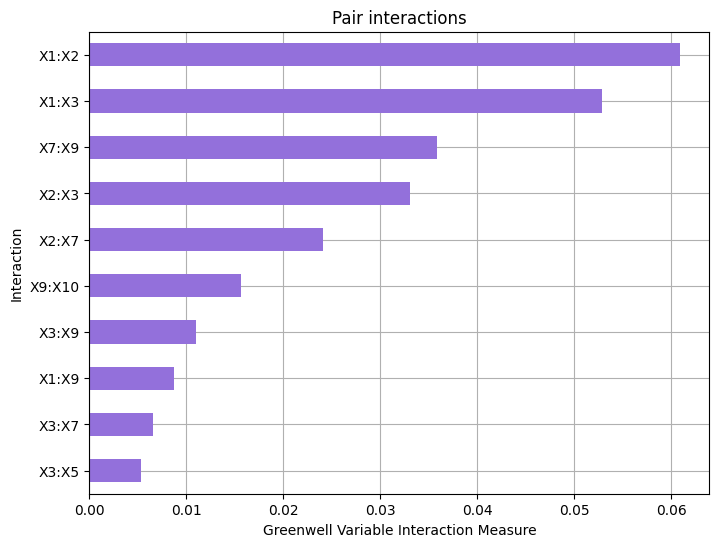

In [12]:
vint.plot("bar_chart", top_k=15)

Pierwsze 7 par zmiennych to rzeczywiście interakcje w danych. 

### H statistic (normalized)

In [13]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


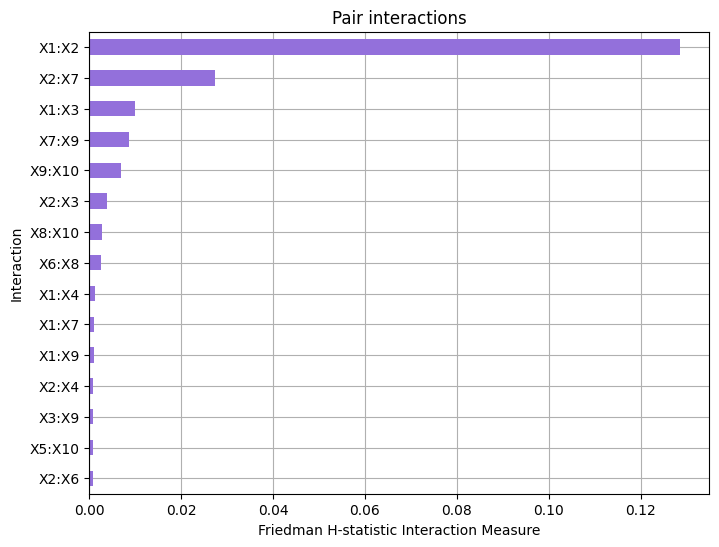

In [14]:
h_stat.plot("bar_chart", top_k = 15)

In [15]:
h_stat.ovo

,Feature 1,Feature 2,Friedman H-statistic Interaction Measure
0,X1,X2,0.128557
1,X2,X7,0.027281
2,X1,X3,0.009844
3,X7,X9,0.008558
4,X9,X10,0.006801
5,X2,X3,0.003777
6,X8,X10,0.002717
7,X6,X8,0.002479
8,X1,X4,0.001250
9,X1,X7,0.001029


Pierwsze 6 par zmiennych to rzeczywiście interakcje w danych. 

### H statistic (unnormalized)

In [16]:
h_stat_unnormalized = FriedmanHStatisticMethod(normalized=False)
h_stat_unnormalized.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it]


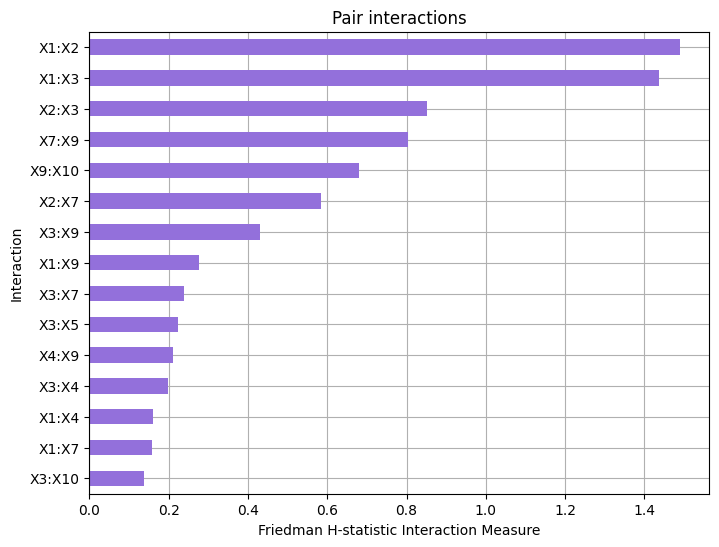

In [17]:
h_stat_unnormalized.plot("bar_chart", top_k=15)

In [18]:
h_stat_unnormalized.ovo

,Feature 1,Feature 2,Friedman H-statistic Interaction Measure
0,X1,X2,1.489518
1,X1,X3,1.437062
2,X2,X3,0.851398
3,X7,X9,0.804447
4,X9,X10,0.680647
5,X2,X7,0.583483
6,X3,X9,0.429692
7,X1,X9,0.276452
8,X3,X7,0.237947
9,X3,X5,0.222910


Pierwsze 6 par zmiennych to rzeczywiście interakcje w danych. 

### Sejong Oh Method

In [19]:
perf_based = SejongOhMethod()
perf_based.fit(model, X_test, y_test, show_progress=True)

Calculating feature importance: 100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


In [20]:
perf_based.ovo

,Feature 1,Feature 2,Sejong Oh Performance Based Interaction Measure
0,X3,X9,0.203547
1,X1,X3,0.101293
2,X2,X3,0.086019
3,X1,X9,0.084185
4,X3,X7,0.080607
5,X1,X2,0.063139
6,X7,X9,0.060823
7,X2,X9,0.041967
8,X1,X7,0.039073
9,X3,X4,0.035969


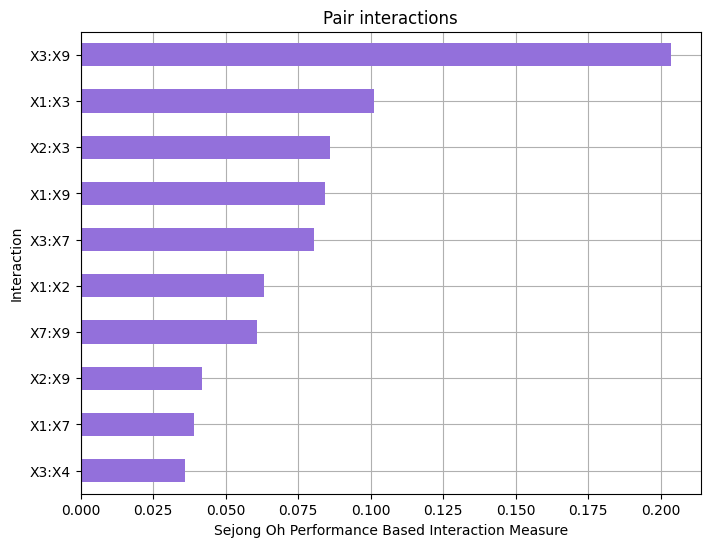

In [21]:
perf_based.plot("bar_chart", top_k=15)

In [22]:
perf_based.ovo

,Feature 1,Feature 2,Sejong Oh Performance Based Interaction Measure
0,X3,X9,0.203547
1,X1,X3,0.101293
2,X2,X3,0.086019
3,X1,X9,0.084185
4,X3,X7,0.080607
5,X1,X2,0.063139
6,X7,X9,0.060823
7,X2,X9,0.041967
8,X1,X7,0.039073
9,X3,X4,0.035969


Ta metoda działa najgorzej. Interakcja wskazana jako najwazniejsza nie jest zdefiniowana wprost w danych. 
Na dalszych pozycjach rowniez pojawia sie wiele nieoczekiwanych par zmiennych. 

### Klasyfikacja

In [23]:
def logit2prob(x):
    return np.exp(x)/(1+np.exp(x))

In [24]:
y_cls = np.random.binomial(1, logit2prob(f1(X)))

In [25]:
exp1_data = pd.DataFrame(np.hstack((X, y_cls.reshape(5000, 1))))
exp1_data.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'y']
X = exp1_data.drop('y', axis=1)
y = exp1_data['y']
X_train, y_train = X.iloc[:4500], y.iloc[:4500]
X_test, y_test = X.iloc[4500:], y.iloc[4500:]

In [26]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt").fit(X_train, y_train)

### Greenwell Method

In [27]:
import shap
X_test_repr = pd.DataFrame(shap.kmeans(X_test, 50).data, columns = X_test.columns)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [28]:
vint = GreenwellMethod()
vint.fit(model, X_test_repr, show_progress=True) 

Calculating feature importance: 100%|██████████| 10/10 [00:00<00:00, 16.29it/s]


In [29]:
vint.ovo

,Feature 1,Feature 2,Greenwell Variable Interaction Measure
0,X1,X3,0.029844
1,X3,X9,0.023756
2,X1,X2,0.012611
3,X7,X9,0.007062
4,X1,X7,0.007058
5,X3,X7,0.006596
6,X2,X9,0.006586
7,X1,X9,0.006052
8,X3,X10,0.005354
9,X2,X3,0.005214


In [30]:
vint.ovo.to_csv("../experiments/results/f1_greenwell_cls.csv")

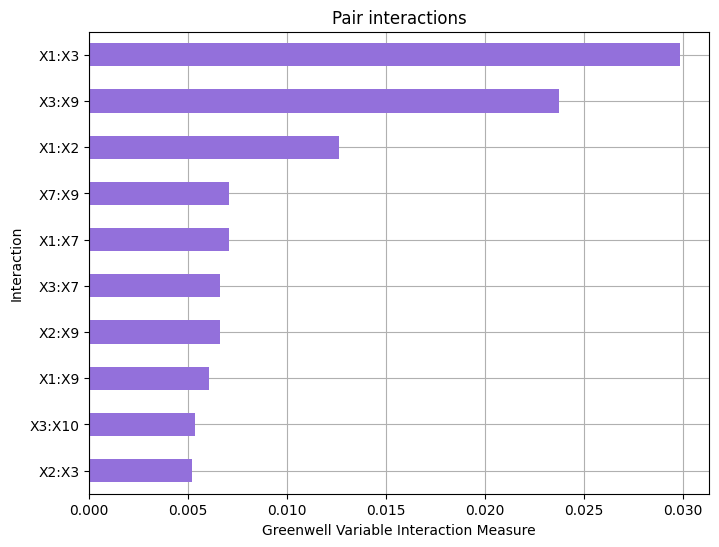

In [31]:
vint.plot("bar_chart", top_k=15)

### H statistic (normalized)

In [32]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


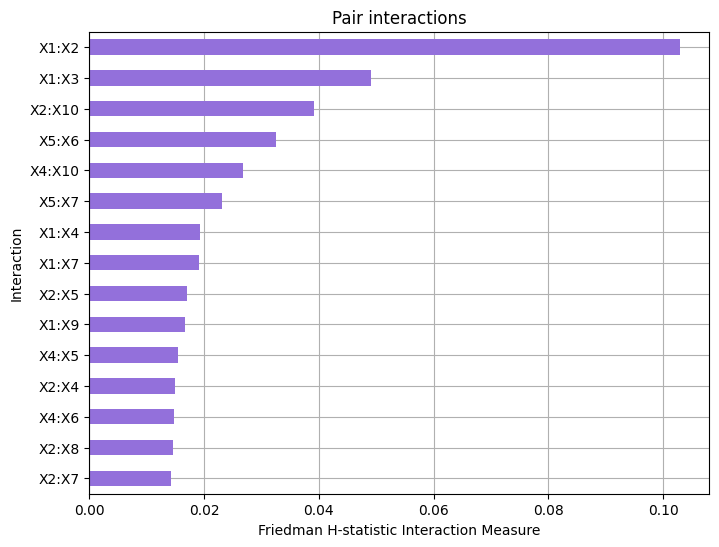

In [33]:
h_stat.plot("bar_chart", top_k = 15)

### H statistic (unnormalized)

In [34]:
h_stat_unnormalized = FriedmanHStatisticMethod(normalized=False)
h_stat_unnormalized.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


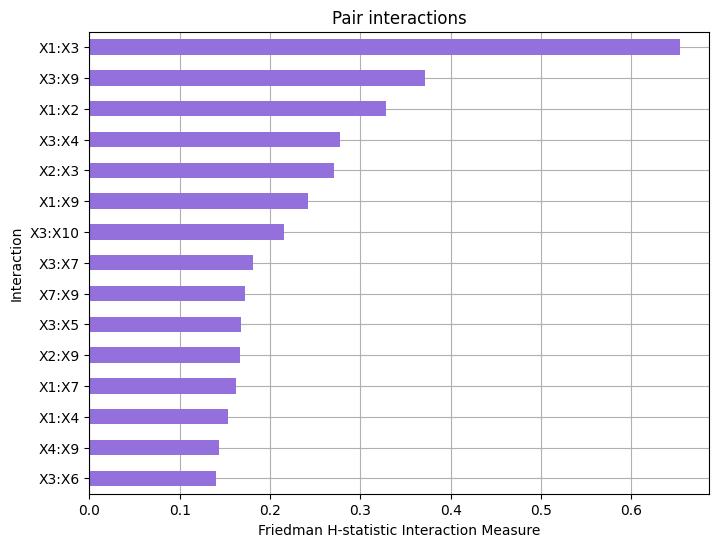

In [35]:
h_stat_unnormalized.plot("bar_chart", top_k=15)

In [36]:
h_stat_unnormalized.ovo

,Feature 1,Feature 2,Friedman H-statistic Interaction Measure
0,X1,X3,0.653463
1,X3,X9,0.371318
2,X1,X2,0.328836
3,X3,X4,0.277986
4,X2,X3,0.271216
5,X1,X9,0.242505
6,X3,X10,0.215200
7,X3,X7,0.181190
8,X7,X9,0.172064
9,X3,X5,0.167784


### Sejong Oh Method

In [37]:
perf_based = SejongOhMethod()
perf_based.fit(model, X_test, y_test, show_progress=True)

Calculating feature importance: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


In [38]:
perf_based.ovo

,Feature 1,Feature 2,Sejong Oh Performance Based Interaction Measure
0,X3,X5,0.019608
1,X4,X9,0.019503
2,X3,X6,0.019117
3,X3,X10,0.019048
4,X2,X3,0.017231
5,X8,X9,0.015736
6,X3,X8,0.015629
7,X1,X3,0.014978
8,X1,X2,0.014379
9,X3,X7,0.014210


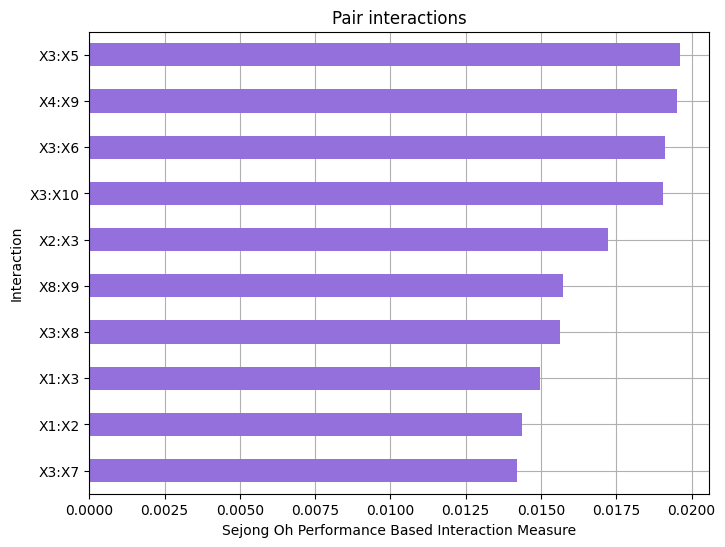

In [39]:
perf_based.plot("bar_chart", top_k=15)

In [40]:
perf_based.ovo

,Feature 1,Feature 2,Sejong Oh Performance Based Interaction Measure
0,X3,X5,0.019608
1,X4,X9,0.019503
2,X3,X6,0.019117
3,X3,X10,0.019048
4,X2,X3,0.017231
5,X8,X9,0.015736
6,X3,X8,0.015629
7,X1,X3,0.014978
8,X1,X2,0.014379
9,X3,X7,0.014210
